In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew  
%matplotlib inline

In [272]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [273]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [274]:
train.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [275]:
test.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         4
LotFrontage    227
LotArea          0
dtype: int64

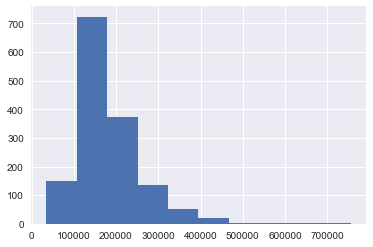

In [276]:
# data is right skewed
train['SalePrice'].hist()

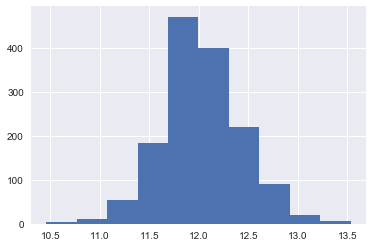

In [277]:
# After log the deviation seems to be normal 
np.log1p(train['SalePrice']).hist()

In [278]:
# get numeric and non numeric cols
numeric_cols = [ col for col in train.columns if train[col].dtype!="object" ]
categorical_cols = [col for col in train.columns if col not in numeric_cols]

In [279]:
bothdf = pd.concat([train,test],axis=0)

In [280]:
empty_df =  pd.DataFrame(bothdf.isnull().sum(),columns=['Empty Values'])
empty_df[empty_df['Empty Values']>1000]

,Empty Values
Alley,2721
Fence,2348
FireplaceQu,1420
MiscFeature,2814
PoolQC,2909
SalePrice,1459


In [281]:
bothdf = bothdf.drop(['Alley','Fence','FireplaceQu','MiscFeature','PoolQC'],axis=1)
empty_df = empty_df.drop(['Alley','Fence','FireplaceQu','MiscFeature','PoolQC'],axis=0)


In [282]:
empty_df = empty_df[empty_df['Empty Values']>0]
empty_df = empty_df.sort_values(ascending=False,by='Empty Values')
empty_df.head()

,Empty Values
SalePrice,1459
LotFrontage,486
GarageYrBlt,159
GarageQual,159
GarageFinish,159


In [283]:
# get the highest correlation wrt LotFrontage
# seems like LotFrontage has high corr wrt LotArea,1stFlrSF,GrLivArea,GarageArea
corrdf = pd.DataFrame(bothdf.corr())
corrdf['LotFrontage'].sort_values(ascending=False).head()

LotFrontage    1.000000
LotArea        0.489896
1stFlrSF       0.458247
GrLivArea      0.382462
GarageArea     0.359786
Name: LotFrontage, dtype: float64

In [284]:
# preparing internal ML model to get lotfrontage missing values
bothdf[bothdf['LotFrontage'].notnull()].head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [285]:
# preparing the dataframe for processing
lotFr = bothdf[['LotArea','1stFlrSF','GrLivArea','GarageArea','LotFrontage']]
lotFr_nn = lotFr[lotFr['LotFrontage'].notnull() & lotFr['GarageArea'].notnull()]
lotFr.count()
lotFr_nn.isnull().sum()

LotArea        0
1stFlrSF       0
GrLivArea      0
GarageArea     0
LotFrontage    0
dtype: int64

In [286]:
lotFr_nn.head()

,LotArea,1stFlrSF,GrLivArea,GarageArea,LotFrontage
0,8450,856,1710,548.0,65.0
1,9600,1262,1262,460.0,80.0
2,11250,920,1786,608.0,68.0
3,9550,961,1717,642.0,60.0
4,14260,1145,2198,836.0,84.0


In [294]:
X_lot = lotFr_nn.iloc[:, :-1].values
y_lot = lotFr_nn.iloc[:, 4:].values
y_lot

array([[  65.],
       [  80.],
       [  68.],
       ..., 
       [ 160.],
       [  62.],
       [  74.]])

In [288]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lot, y_lot, test_size = 0.2, random_state = 0)

In [297]:
from sklearn.preprocessing import StandardScaler
sc_lotfr_X = StandardScaler()
sc_lotfr_Y = StandardScaler()

X_lot_train = sc_lotfr_X.fit_transform(X_train)
X_lot_test = sc_lotfr_X.transform(X_test)

y_lot_train = sc_lotfr_Y.fit_transform(y_train)
y_lot_test = sc_lotfr_Y.transform(y_test)
X_lot_test

array([[ 1.68003075, -0.20157271,  0.15567425,  0.26288401],
       [-0.18552924, -0.2798153 , -0.8838625 , -0.31187824],
       [ 0.29960353,  0.8547022 ,  0.01603498,  0.0383675 ],
       ..., 
       [ 0.2334953 ,  1.17256271,  0.26816143,  1.78061558],
       [ 0.50548348,  0.5612925 , -0.21669713,  1.91532548],
       [ 0.25310983,  0.93538987,  0.08003631,  1.43036983]])

In [328]:
from sklearn.svm import SVR
lot_reg = SVR(C=0.82, kernel='linear')
lot_reg.fit(X_lot_train,y_lot_train.ravel())

SVR(C=0.82, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [329]:
fr_preds = lot_reg.predict(X_lot_test)
fr_preds

array([  1.59470539e+00,  -2.35858145e-01,   4.36977278e-01,
        -1.02648799e+00,  -1.29731675e-01,  -3.64022329e-01,
         9.23472790e-02,   2.16116254e-01,   1.05874941e-01,
         1.27536744e+00,   1.39073652e+00,  -3.59520529e-01,
         8.05898248e-01,  -6.77255917e-01,   5.83601126e-01,
         6.76358003e-01,  -4.08616455e-01,  -2.18913496e-01,
        -2.22191934e-01,   1.16882913e-01,   5.10876625e-02,
         1.40595101e+00,   8.22323379e-01,   3.39983832e-01,
        -8.65480287e-01,  -8.68557521e-02,  -4.27907830e-01,
        -1.07502892e+00,  -5.30919640e-02,   4.74887409e-01,
        -1.27428898e-01,  -7.01912008e-01,  -2.56523059e-01,
        -6.82101866e-01,  -1.67256797e-01,   2.41357826e+00,
        -1.27464044e-01,   1.77966036e-01,   1.31082175e-01,
         1.28887737e-01,  -3.64055275e-01,   8.36941645e-02,
        -2.10515021e-01,  -3.30553590e-01,   7.29739192e-02,
        -1.63342870e-01,   1.89071523e-01,   2.93164547e-02,
        -3.39170630e-01,

In [330]:
from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(lot_reg,X_lot_test,y_lot_test,cv=5,n_jobs=-1)
print(cross_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (cross_score.mean(), cross_score.std() * 2))

[ 0.36072232  0.29508108  0.33045256  0.50327162  0.2436653 ]
Accuracy: 0.35 (+/- 0.17)


In [331]:
from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_lot_test, fr_preds)))


RMSE: 0.720177837173


In [289]:
# without transforming
from sklearn.tree import DecisionTreeRegressor
rreg = DecisionTreeRegressor()
rreg.fit(X_train,y_train.ravel())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [290]:
new_preds = rreg.predict(X_test)
new_preds

array([ 104.,   60.,   85.,   30.,   66.,   50.,   50.,   63.,   73.,
        100.,  112.,   60.,  108.,   51.,  100.,   75.,   62.,   45.,
         79.,   65.,   60.,  160.,  110.,   41.,   50.,   66.,   48.,
         24.,   60.,   85.,   62.,   50.,   42.,   60.,   82.,  120.,
         60.,   89.,   82.,   68.,   50.,   68.,   70.,   70.,   60.,
         50.,   84.,   26.,   70.,   88.,   72.,   84.,   76.,   75.,
         60.,   75.,   74.,   55.,  124.,   86.,   43.,  101.,   53.,
         62.,   50.,   80.,   99.,   85.,   75.,   24.,   76.,   65.,
         35.,   65.,   70.,   75.,   80.,   50.,   42.,   44.,   85.,
         60.,   70.,   88.,   50.,   52.,   21.,   86.,   60.,   68.,
         70.,   50.,   43.,   60.,   37.,   95.,   22.,   72.,   60.,
         74.,   64.,   64.,   52.,   40.,   98.,   72.,   65.,   70.,
         41.,   64.,   56.,   74.,   66.,   55.,   60.,   63.,   80.,
         56.,   59.,   99.,   75.,   73.,   65.,   63.,   65.,  105.,
         60.,   65.,

In [291]:
from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(new_preds, y_test)))


RMSE: 24.1304207877


In [292]:
from sklearn.model_selection import cross_val_score
cross_score = cross_val_score(rreg,X_train,y_train,cv=5,n_jobs=-1)
print(cross_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (cross_score.mean(), cross_score.std() * 2))

[ 0.08776177  0.12252993  0.05062925  0.14604061  0.01429525]
Accuracy: 0.08 (+/- 0.10)
